In [1]:
# import os
# os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-12.5/nvvm/libdevice'

from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

print("JIT ativado?", tf.config.optimizer.get_jit())
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

# Parâmetros (mesmos usados no preprocessing)
MAXLEN_DOC = 100
MAXLEN_SUM = 30
VOCAB_IN   = 10000
VOCAB_OUT  = 6000
BATCH_ORIG = 16384
AUTOTUNE   = tf.data.AUTOTUNE
embedding_dim = 128
units=256
VAL_SPLIT = 0.2
SHUFFLE_BUFFER   = 10000
# embedding_dim = 32
# units         = 64

# 1) Carregar pipelines de vetorização salvos
tv_doc = load_model("/home/olavo-dalberto/models/tv_doc_model.keras")
tv_sum = load_model("/home/olavo-dalberto/models/tv_sum_model.keras")
vocab_size_input = len(tv_doc.get_layer(index=0).get_vocabulary())
vocab_size_output = len(tv_sum.get_layer(index=0).get_vocabulary())

2025-08-07 20:05:20.267710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754607920.975399    9410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754607921.141633    9410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754607922.711067    9410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754607922.711095    9410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754607922.711099    9410 computation_placer.cc:177] computation placer alr

JIT ativado? autoclustering
GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1754607947.012688    9410 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1834 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
from tensorflow.keras.layers import LSTM
# --- ENCODER ---
encoder_inputs = Input(shape=(MAXLEN_DOC,), name='encoder_inputs')
enc_emb = Embedding(vocab_size_input, embedding_dim, name='encoder_embedding')(encoder_inputs)
# Substituindo GRU por LSTM
encoder_lstm = LSTM(units, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(enc_emb)
# Encoder model para inferência
encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h_enc, state_c_enc],
    name='encoder_model'
)

# --- DECODER (para treino) ---
decoder_inputs = Input(shape=(MAXLEN_SUM+1,), name='decoder_inputs')  # incluindo <sos>
dec_emb = Embedding(vocab_size_output, embedding_dim, name='decoder_embedding')(decoder_inputs)

# Substituindo GRU por LSTM
decoder_lstm = LSTM(
    units,
    return_sequences=True,
    return_state=True,
    name='decoder_lstm'
)
# Usa os dois estados h e c do encoder
dec_outputs, _, _ = decoder_lstm(
    dec_emb,
    initial_state=[state_h_enc, state_c_enc]
)

# Atenção, concat e TimeDistributed(Dense)
attn = Attention(name='attention_layer')([dec_outputs, encoder_outputs])
concat = Concatenate(axis=-1, name='concat_layer')([dec_outputs, attn])
output_dense = TimeDistributed(
    Dense(vocab_size_output, activation='softmax'),
    name='output_dense'
)
final_outputs = output_dense(concat)

# Modelo end-to-end
e2e_model = Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=final_outputs,
    name='seq2seq_lstm'
)
e2e_model.summary()


Model: "seq2seq_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 100, 128)  │  2,560,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 31, 128)   │  1,536,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 100,      │    394,240 │ encoder_embeddin… │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 31, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 31, 256)   │          0 │ decoder_lstm[0][… │
│ (Attention)         │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 31, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 31, 12000) │  6,156,000 │ concat_layer[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,040,480 (42.12 MB)

 Trainable params: 11,040,480 (42.12 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from tensorflow.keras.layers import Layer
# --- Inputs de inferência ---
dec_token      = Input(shape=(1,),               name='dec_token')      # próxima palavra (batch,1)
enc_outs_inf   = Input(shape=(None, units),      name='enc_outputs')    # saída sequencial do encoder
dec_state_h_in = Input(shape=(units,),           name='dec_state_h')    # estado oculto h do decoder
dec_state_c_in = Input(shape=(units,),           name='dec_state_c')    # estado de célula c do decoder

# --- Embedding e LSTM do decoder ---
dec_emb_layer  = e2e_model.get_layer('decoder_embedding')
lstm_layer     = e2e_model.get_layer('decoder_lstm')
attn_layer     = e2e_model.get_layer('attention_layer')
concat_layer   = e2e_model.get_layer('concat_layer')
dense_layer    = e2e_model.get_layer('output_dense')

# 1) Embedding
dec_emb_inf    = dec_emb_layer(dec_token)  # (batch, 1, emb_dim)

# 2) LSTM passo único
dec_outputs_inf, state_h_inf, state_c_inf = lstm_layer(
    dec_emb_inf,
    initial_state=[dec_state_h_in, dec_state_c_in]
)  # dec_outputs_inf: (batch, 1, units)

# 3) Atenção
context_inf    = attn_layer([dec_outputs_inf, enc_outs_inf])  # (batch, 1, units)

# 4) Concatenação
dec_concat_inf = concat_layer([dec_outputs_inf, context_inf])  # (batch, 1, units*2)

# 5) Dense (softmax)
dec_logits_inf = dense_layer(dec_concat_inf)  # (batch, 1, vocab_size_output)

# --- Modelo de inferência do decoder ---
decoder_model = Model(
    inputs=[dec_token, enc_outs_inf, dec_state_h_in, dec_state_c_in],
    outputs=[dec_logits_inf, state_h_inf, state_c_inf],
    name='decoder_model'
)

decoder_model.summary()

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_token           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 1, 128)    │  1,536,000 │ dec_token[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_state_h         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_state_c         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 256),  │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ dec_state_h[0][0… │
│                     │ (None, 256)]      │            │ dec_state_c[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_outputs         │ (None, None, 256) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 1, 256)    │          0 │ decoder_lstm[1][… │
│ (Attention)         │                   │            │ enc_outputs[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 1, 512)    │          0 │ decoder_lstm[1][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 1, 12000)  │  6,156,000 │ concat_layer[1][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,086,240 (30.85 MB)

 Trainable params: 8,086,240 (30.85 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
ds = tf.data.Dataset.load(
    "vectorized_gigaword_ds",
    element_spec={
        'document': tf.TensorSpec((BATCH_ORIG, MAXLEN_DOC), tf.int64),
        'summary' : tf.TensorSpec((BATCH_ORIG, MAXLEN_SUM+2), tf.int64),
    }
)
# debug_raw = ds.unbatch().take(512)
# batch = next(iter(debug_raw))
batch = next(iter(ds))
print("Batch.document shape:", batch['document'].shape)  # (BATCH_ORIG, 100)
print("Batch.summary  shape:", batch['summary'].shape)   # (BATCH_ORIG, 32)

Batch.document shape: (16384, 100)
Batch.summary  shape: (16384, 32)


In [5]:
raw = ds.unbatch()
print("document spec:", raw.element_spec['document'].shape)
print("summary  spec:", raw.element_spec['summary'].shape)

document spec: (100,)
summary  spec: (32,)


In [6]:
def make_training_example(x):
    enc_in = x['document']          # (100,)
    summ   = x['summary']           # (32,)
    dec_in = summ[:-1]              # (31,) remove <eos>
    dec_tr = summ[1:]               # (31,) remove <sos>
    return ((enc_in, dec_in), dec_tr)


# debug_paired = debug_raw.map(make_training_example, num_parallel_calls=AUTOTUNE)
paired = raw.map(make_training_example, num_parallel_calls=AUTOTUNE)
N = tf.data.experimental.cardinality(paired).numpy()
val_n = int(N*VAL_SPLIT)
shuffled = paired.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
total = tf.data.experimental.cardinality(shuffled).numpy()


val_ds = shuffled.take(val_n).cache().batch(32).prefetch(AUTOTUNE)
train_ds = shuffled.skip(val_n).cache().batch(32).prefetch(AUTOTUNE)

In [7]:
train_ds.element_spec

((TensorSpec(shape=(None, 100), dtype=tf.int64, name=None),
  TensorSpec(shape=(None, 31), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, 31), dtype=tf.int64, name=None))

In [8]:
eos_id = tv_sum.layers[0].get_vocabulary().index('eos')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,
                                                       reduction='none')

def masked_loss(y_true, y_pred):
    loss = loss_fn(y_true, y_pred)                   # (batch, seq_len)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) * tf.cast(tf.not_equal(y_true, eos_id), tf.float32)
    return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

In [9]:
opt = tf.keras.optimizers.Adam(1e-4)

e2e_model.compile(
    optimizer=opt,
    loss=masked_loss,
    metrics=['sparse_categorical_accuracy'],
    run_eagerly=False
    )

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping('val_loss',patience=5,restore_best_weights=True),
    ReduceLROnPlateau('val_loss',factor=0.5,patience=3),
    ModelCheckpoint('best_seq2seq.h5','val_loss',save_best_only=True)
]

history = e2e_model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=callbacks
                )


Epoch 1/20


I0000 00:00:1754608510.450849   11156 service.cc:152] XLA service 0x78e11c006650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754608510.450867   11156 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
I0000 00:00:1754608510.656624   11156 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1754608511.265570   11156 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-07 20:15:23.115935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-07 20:15:25.218209: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 16 bytes spill stores, 16 bytes spill loads

2025-08-07 20:15:

95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 6.0722 - sparse_categorical_accuracy: 0.0346

2025-08-07 21:17:55.158815: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-07 21:17:55.158843: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert/data_3/_10]]
2025-08-07 21:17:55.158855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-07 21:17:55.158862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-07 21:17:55.158870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-07 21:17:55.

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3934s 41ms/step - loss: 6.0692 - sparse_categorical_accuracy: 0.0347 - val_loss: 4.5908 - val_sparse_categorical_accuracy: 0.0616 - learning_rate: 1.0000e-04
Epoch 2/20
95013/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 4.3964 - sparse_categorical_accuracy: 0.0660

2025-08-07 22:22:13.990941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads

2025-08-07 22:22:25.284435: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_pad_fusion_1', 24 bytes spill stores, 24 bytes spill loads



95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 4.3964 - sparse_categorical_accuracy: 0.0660

2025-08-07 22:22:26.595935: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/TensorScatterUpdate/_66]]
2025-08-07 22:22:26.595980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-07 22:22:26.595985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16224509083716926013
2025-08-07 22:22:26.595989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-07 22:22:26.595996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6493322276942623032
2025-08-07 22:22:26.596000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-07 22

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3870s 41ms/step - loss: 4.3957 - sparse_categorical_accuracy: 0.0660 - val_loss: 3.9972 - val_sparse_categorical_accuracy: 0.0759 - learning_rate: 1.0000e-04
Epoch 3/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 3.8891 - sparse_categorical_accuracy: 0.0784

2025-08-07 23:27:18.295087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-07 23:27:18.295109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-07 23:27:18.295114: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-07 23:27:18.295118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-07 23:27:18.295124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-07 23:27:18.295128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-07 23:27:18.295132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3887s 41ms/step - loss: 3.8887 - sparse_categorical_accuracy: 0.0784 - val_loss: 3.7043 - val_sparse_categorical_accuracy: 0.0836 - learning_rate: 1.0000e-04
Epoch 4/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 3.6089 - sparse_categorical_accuracy: 0.0858

2025-08-08 00:32:33.416671: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_84]]
2025-08-08 00:32:33.764151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 00:32:33.764162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 00:32:33.764172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 00:32:33.764227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 00:32:33.764236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 00:32:33.764245: I tensorflow/c

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3912s 41ms/step - loss: 3.6086 - sparse_categorical_accuracy: 0.0859 - val_loss: 3.5255 - val_sparse_categorical_accuracy: 0.0887 - learning_rate: 1.0000e-04
Epoch 5/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 3.4221 - sparse_categorical_accuracy: 0.0911

2025-08-08 01:37:41.120658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 01:37:41.120681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 01:37:41.120686: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 01:37:41.120691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 01:37:41.120699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 01:37:41.120704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 01:37:41.120708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3909s 41ms/step - loss: 3.4219 - sparse_categorical_accuracy: 0.0911 - val_loss: 3.4043 - val_sparse_categorical_accuracy: 0.0921 - learning_rate: 1.0000e-04
Epoch 6/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 3.2881 - sparse_categorical_accuracy: 0.0951

2025-08-08 02:43:11.803272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 02:43:11.803292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 02:43:11.803298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 02:43:11.803303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 02:43:11.803307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 02:43:11.803311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12589729952117728324
2025-08-08 02:43:11.803315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3933s 41ms/step - loss: 3.2880 - sparse_categorical_accuracy: 0.0951 - val_loss: 3.3179 - val_sparse_categorical_accuracy: 0.0947 - learning_rate: 1.0000e-04
Epoch 7/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 3.1865 - sparse_categorical_accuracy: 0.0981

2025-08-08 03:48:36.909591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 03:48:36.909618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 03:48:36.909624: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 03:48:36.909632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 03:48:36.909640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 03:48:36.909647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 03:48:36.909653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3922s 41ms/step - loss: 3.1864 - sparse_categorical_accuracy: 0.0981 - val_loss: 3.2551 - val_sparse_categorical_accuracy: 0.0966 - learning_rate: 1.0000e-04
Epoch 8/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 3.1066 - sparse_categorical_accuracy: 0.1006

2025-08-08 04:53:54.601387: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_84]]
2025-08-08 04:53:54.601415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 04:53:54.601419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 04:53:54.601422: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 04:53:54.601426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 04:53:54.601431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 04:53:54.601435: I tensorflow/

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3920s 41ms/step - loss: 3.1065 - sparse_categorical_accuracy: 0.1006 - val_loss: 3.2082 - val_sparse_categorical_accuracy: 0.0980 - learning_rate: 1.0000e-04
Epoch 9/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 3.0421 - sparse_categorical_accuracy: 0.1027

2025-08-08 05:59:25.246682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 05:59:25.246707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 05:59:25.246712: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 05:59:25.246716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 05:59:25.246723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 05:59:25.246727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 05:59:25.246747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3930s 41ms/step - loss: 3.0420 - sparse_categorical_accuracy: 0.1027 - val_loss: 3.1724 - val_sparse_categorical_accuracy: 0.0992 - learning_rate: 1.0000e-04
Epoch 10/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 2.9890 - sparse_categorical_accuracy: 0.1044

2025-08-08 07:04:53.058001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 07:04:53.058020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 07:04:53.058025: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 07:04:53.058030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 07:04:53.058035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 07:04:53.058039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 07:04:53.058044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3928s 41ms/step - loss: 2.9889 - sparse_categorical_accuracy: 0.1044 - val_loss: 3.1449 - val_sparse_categorical_accuracy: 0.1001 - learning_rate: 1.0000e-04
Epoch 11/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 2.9450 - sparse_categorical_accuracy: 0.1059

2025-08-08 08:09:23.123437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 08:09:23.123460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 08:09:23.123466: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 08:09:23.123473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 08:09:23.123480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 08:09:23.123486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 08:09:23.123492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3870s 41ms/step - loss: 2.9450 - sparse_categorical_accuracy: 0.1059 - val_loss: 3.1238 - val_sparse_categorical_accuracy: 0.1008 - learning_rate: 1.0000e-04
Epoch 12/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 2.9080 - sparse_categorical_accuracy: 0.1071

2025-08-08 09:14:43.583194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 09:14:43.583219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 09:14:43.583226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 09:14:43.583234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 09:14:43.583239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 09:14:43.583244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12589729952117728324
2025-08-08 09:14:43.583250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3918s 41ms/step - loss: 2.9080 - sparse_categorical_accuracy: 0.1071 - val_loss: 3.1068 - val_sparse_categorical_accuracy: 0.1015 - learning_rate: 1.0000e-04
Epoch 13/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 2.8766 - sparse_categorical_accuracy: 0.1082

2025-08-08 10:19:23.697500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 10:19:23.697518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 10:19:23.697523: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 10:19:23.697528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 10:19:23.697534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 10:19:23.697538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 10:19:23.697542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3875s 41ms/step - loss: 2.8765 - sparse_categorical_accuracy: 0.1082 - val_loss: 3.0942 - val_sparse_categorical_accuracy: 0.1019 - learning_rate: 1.0000e-04
Epoch 14/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 2.8499 - sparse_categorical_accuracy: 0.1092

2025-08-08 11:22:47.677711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 11:22:47.677734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 11:22:47.677768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 11:22:47.677836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 11:22:47.677851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 11:22:47.677857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12589729952117728324
2025-08-08 11:22:47.677861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3805s 40ms/step - loss: 2.8499 - sparse_categorical_accuracy: 0.1092 - val_loss: 3.0840 - val_sparse_categorical_accuracy: 0.1023 - learning_rate: 1.0000e-04
Epoch 15/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 2.8268 - sparse_categorical_accuracy: 0.1100

2025-08-08 12:25:40.869679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 12:25:40.869695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 12:25:40.869699: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 12:25:40.869703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 12:25:40.869708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 12:25:40.869711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 12:25:40.869714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3772s 40ms/step - loss: 2.8267 - sparse_categorical_accuracy: 0.1100 - val_loss: 3.0759 - val_sparse_categorical_accuracy: 0.1027 - learning_rate: 1.0000e-04
Epoch 16/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 2.8067 - sparse_categorical_accuracy: 0.1108

2025-08-08 13:28:52.784185: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_84]]
2025-08-08 13:28:52.784243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 13:28:52.784249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 13:28:52.784252: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 13:28:52.784256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 13:28:52.784260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 13:28:52.784264: I tensorflow/

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3791s 40ms/step - loss: 2.8066 - sparse_categorical_accuracy: 0.1108 - val_loss: 3.0699 - val_sparse_categorical_accuracy: 0.1030 - learning_rate: 1.0000e-04
Epoch 17/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 2.7886 - sparse_categorical_accuracy: 0.1115

2025-08-08 14:32:06.713778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 14:32:06.713803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 14:32:06.713819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 14:32:06.713822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 14:32:06.713831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 14:32:06.713837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12589729952117728324
2025-08-08 14:32:06.713843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3797s 40ms/step - loss: 2.7886 - sparse_categorical_accuracy: 0.1115 - val_loss: 3.0649 - val_sparse_categorical_accuracy: 0.1033 - learning_rate: 1.0000e-04
Epoch 18/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 2.7726 - sparse_categorical_accuracy: 0.1121

2025-08-08 15:35:40.964208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 15:35:40.964230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 15:35:40.964236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 15:35:40.964244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 15:35:40.964248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 15:35:40.964252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12589729952117728324
2025-08-08 15:35:40.964256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3815s 40ms/step - loss: 2.7726 - sparse_categorical_accuracy: 0.1121 - val_loss: 3.0610 - val_sparse_categorical_accuracy: 0.1035 - learning_rate: 1.0000e-04
Epoch 19/20
95015/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 2.7583 - sparse_categorical_accuracy: 0.1126

2025-08-08 16:39:15.455051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 16:39:15.455078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7935162576584690087
2025-08-08 16:39:15.455085: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14444277082442189607
2025-08-08 16:39:15.455093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16932823643528648449
2025-08-08 16:39:15.455101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16243392101439554210
2025-08-08 16:39:15.455108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 16:39:15.455115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3814s 40ms/step - loss: 2.7583 - sparse_categorical_accuracy: 0.1126 - val_loss: 3.0584 - val_sparse_categorical_accuracy: 0.1036 - learning_rate: 1.0000e-04
Epoch 20/20
95014/95437 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 2.7457 - sparse_categorical_accuracy: 0.1131

2025-08-08 17:43:27.596587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8390592836201218798
2025-08-08 17:43:27.596615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15910083173424393158
2025-08-08 17:43:27.596629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12589729952117728324
2025-08-08 17:43:27.596633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17353194868394393789
2025-08-08 17:43:27.596656: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 16187953088611845434
2025-08-08 17:43:27.596666: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 16651275403716161074
2025-08-08 17:43:27.596672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous rec

95437/95437 ━━━━━━━━━━━━━━━━━━━━ 3851s 40ms/step - loss: 2.7457 - sparse_categorical_accuracy: 0.1131 - val_loss: 3.0566 - val_sparse_categorical_accuracy: 0.1037 - learning_rate: 1.0000e-04


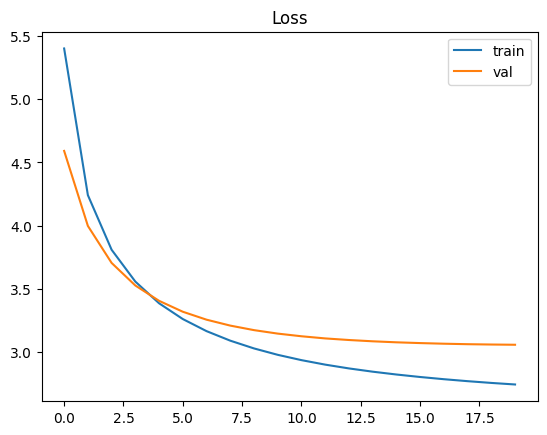

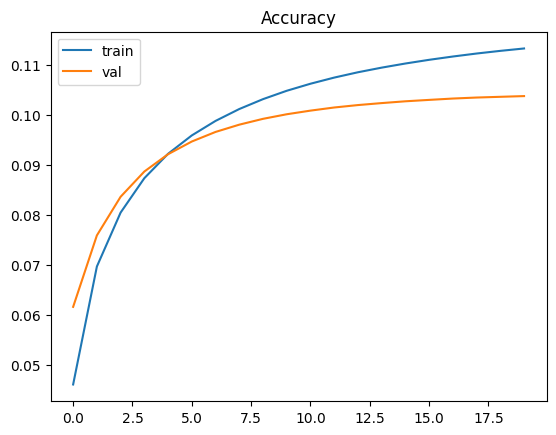

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()
plt.title('Loss')
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'],label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'],label='val')
plt.legend()
plt.title('Accuracy')
plt.show()

In [12]:
import os
os.makedirs('/mnt/dados/tmp', exist_ok=True)
os.environ['TMPDIR'] = '/mnt/dados/tmp'

In [13]:
import numpy as np

vocab_doc = np.load("/home/olavo-dalberto/models/vocab_doc.npy", allow_pickle=True)
vocab_sum = np.load("/home/olavo-dalberto/models/vocab_sum.npy", allow_pickle=True)
tv_doc = tf.keras.models.load_model("/home/olavo-dalberto/models/tv_doc_model.keras")
tv_sum = tf.keras.models.load_model("/home/olavo-dalberto/models/tv_sum_model.keras")

In [11]:
vocab_sum

array(['', '[UNK]', 'sos', ..., 'likud', 'lacks', 'hat'], dtype='<U18')

In [14]:
encoder_model.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_embedding (Embedding)   │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ [(None, 100, 256),     │       394,240 │
│                                 │ (None, 256), (None,    │               │
│                                 │ 256)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954,240 (11.27 MB)

 Trainable params: 2,954,240 (11.27 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
decoder_model.summary()

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_token           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 1, 128)    │  1,536,000 │ dec_token[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_state_h         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_state_c         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 256),  │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ dec_state_h[0][0… │
│                     │ (None, 256)]      │            │ dec_state_c[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_outputs         │ (None, None, 256) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 1, 256)    │          0 │ decoder_lstm[1][… │
│ (Attention)         │                   │            │ enc_outputs[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 1, 512)    │          0 │ decoder_lstm[1][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 1, 12000)  │  6,156,000 │ concat_layer[1][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,086,240 (30.85 MB)

 Trainable params: 8,086,240 (30.85 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import numpy as np, heapq
sum_vocab = tv_sum.layers[0].get_vocabulary()
sos_id, eos_id = sum_vocab.index('sos'), sum_vocab.index('eos')

def beam_search_decode(text, beam_width=5, alpha=0.6, min_len=4, max_len=None):
    """
    Beam search compatível com encoder/decoder que retornam:
      - encoder_model.predict(...) -> (enc_outs, h)  OR (enc_outs, h, c)
      - decoder_model.predict(...) -> (logits, h_new) OR (logits, h_new, c_new)
    """
    if max_len is None:
        max_len = MAXLEN_SUM + 2

    # 1) vectoriza e codifica
    doc_vec = tv_doc.predict(tf.constant([[text]]), verbose=0)
    enc_preds = encoder_model.predict(doc_vec, verbose=0)

    # normalize encoder outputs (support 2 or 3 returns)
    if len(enc_preds) == 2:
        enc_outs, h_enc = enc_preds
        c_enc = None
    elif len(enc_preds) == 3:
        enc_outs, h_enc, c_enc = enc_preds
    else:
        raise RuntimeError("encoder_model returned unexpected number of outputs: %d" % len(enc_preds))

    # hypotheses: list of tuples (score, token_seq, h_state, c_state)
    # initial hypothesis contains only the sos token
    hyp = [(0.0, [sos_id], h_enc, c_enc)]
    completed = []

    for step in range(max_len):
        all_candidates = []
        for score, seq, h_state, c_state in hyp:
            # if last token is eos, move to completed
            if seq[-1] == eos_id:
                completed.append((score, seq, h_state, c_state))
                continue

            # feed last token to decoder
            token_in = np.array([[seq[-1]]], dtype=np.int32)

            # call decoder depending on expected inputs/outputs
            # detect decoder_model output arity by calling predict on single step already built decoder_model
            # but to avoid calling shape-inference each step we branch by presence of c_state
            if c_state is None:
                # expected decoder signature: [token, enc_outs, state_h] -> (logits, state_h_new)
                preds = decoder_model.predict([token_in, enc_outs, h_state], verbose=0)
                # preds could be (logits, h_new) or nested; handle both
                if len(preds) == 2:
                    logits, h_new = preds
                    c_new = None
                elif len(preds) == 3:  # fallback
                    logits, h_new, c_new = preds
                else:
                    raise RuntimeError("decoder_model returned unexpected number of outputs: %d" % len(preds))
            else:
                # expected decoder signature: [token, enc_outs, state_h, state_c] -> (logits, h_new, c_new)
                preds = decoder_model.predict([token_in, enc_outs, h_state, c_state], verbose=0)
                if len(preds) == 3:
                    logits, h_new, c_new = preds
                elif len(preds) == 2:
                    logits, h_new = preds
                    c_new = None
                else:
                    raise RuntimeError("decoder_model returned unexpected number of outputs: %d" % len(preds))

            # logits shape: (batch=1, 1, V)
            logp = np.log(logits[0, 0, :] + 1e-9)

            # forbid EOS too early
            if step < min_len:
                logp[eos_id] = -1e9

            # pick top-K candidates from this hypothesis
            top_ids = np.argsort(logp)[-beam_width:]  # ascending -> take last
            for idx in top_ids:
                new_score = score + float(logp[idx])
                new_seq = seq + [int(idx)]
                # make copies of states (they are small)
                new_h = np.array(h_new, copy=True) if h_new is not None else None
                new_c = np.array(c_new, copy=True) if (c_new is not None) else None
                all_candidates.append((new_score, new_seq, new_h, new_c))

        # keep best beam_width hypotheses
        if not all_candidates:
            break
        hyp = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[0])

        # finish early if we have enough completed sequences
        if len(completed) >= beam_width:
            break

    # select best (completed else current) with length-penalty
    def lp(score, length): return score / (length ** alpha)
    candidates = completed if completed else hyp
    best = max(candidates, key=lambda x: lp(x[0], len(x[1])))

    # map ids -> tokens, filter out sos/eos
    result_ids = [i for i in best[1] if i not in (sos_id, eos_id)]
    tokens = [sum_vocab[i] if i < len(sum_vocab) else '[UNK]' for i in result_ids]
    return ' '.join(tokens)

In [20]:
# print(decode_sequence("Este é um texto de teste para sumarização."))
raw_text = """The government said Monday it has concluded  
talks with the Walt Disney Co. about building a theme park here, 
and an official said the two sides had reached a deal.
</P>"""

beam_search_decode(raw_text)

/tmp/ipykernel_9410/3564304145.py:69: RuntimeWarning: divide by zero encountered in log
  logp = np.log(logits[0, 0, :] + 1e-9)
/tmp/ipykernel_9410/3564304145.py:73: RuntimeWarning: overflow encountered in cast
  logp[eos_id] = -1e9


'disney says it is close to deal with [UNK] theme park company says it is building a theme park near agreement with disney theme park in hong kong ends in talks with'

In [23]:
e2e_model.save('/home/olavo-dalberto/models/seq2seq_model.keras', include_optimizer=True)

In [ ]:
import json
from rouge_score import rouge_scorer

def ids_to_text(ids, vocab):
    tokens = [vocab[i] for i in ids if i < len(vocab)]
    # Remove <sos> e <eos>
    tokens = [t for t in tokens if t not in ('sos', 'eos', '[UNK]')]
    return ' '.join(tokens)

sum_vocab = tv_sum.layers[0].get_vocabulary()
refs = []
cands = []

for (enc_in, dec_in), dec_tr in val_ds.unbatch().take(100):
    # Converte entrada para texto
    doc_text = ids_to_text(enc_in.numpy(), tv_doc.layers[0].get_vocabulary())
    # Gera predição
    pred = beam_search_decode(doc_text)
    # Converte referência para texto
    ref = ids_to_text(dec_tr.numpy(), sum_vocab)
    refs.append(ref)
    cands.append(pred)

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
scores = [scorer.score(ref, cand) for ref, cand in zip(refs, cands)]

# 4) imprime média aritmética
def avg(metric_name):
    return sum(s[metric_name].fmeasure for s in scores) / len(scores)


print("Avg ROUGE-1 F1:", avg("rouge1"))
print("Avg ROUGE-2 F1:", avg("rouge2"))
print("Avg ROUGE-L F1:", avg("rougeL"))

/tmp/ipykernel_9410/3564304145.py:69: RuntimeWarning: divide by zero encountered in log
  logp = np.log(logits[0, 0, :] + 1e-9)
/tmp/ipykernel_9410/3564304145.py:73: RuntimeWarning: overflow encountered in cast
  logp[eos_id] = -1e9


Avg ROUGE-1 F1: 0.19601669078508113
Avg ROUGE-2 F1: 0.0737315885372972
Avg ROUGE-L F1: 0.17719472657446378


In [29]:

# 1) carrega samples
with open("/home/olavo-dalberto/text_summarizer_seq2seq/data/rouge_test_samples.json", "r", encoding="utf-8") as f:
    samples = json.load(f)

docs = [s["document"] for s in samples]
refs = [s["reference"] for s in samples]

# 2) gera previsões com seu decode
cands = []
for doc in docs:
    pred = beam_search_decode(doc)  
    cands.append(pred)

# 3) calcula ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
scores = [scorer.score(ref, cand) for ref, cand in zip(refs, cands)]

# 4) imprime médias das metricas simples
def avg(metric_name):
    return sum(s[metric_name].fmeasure for s in scores) / len(scores)

print("Avg ROUGE-1 F1:", avg("rouge1"))
print("Avg ROUGE-2 F1:", avg("rouge2"))
print("Avg ROUGE-L F1:", avg("rougeL"))


/tmp/ipykernel_9410/3564304145.py:69: RuntimeWarning: divide by zero encountered in log
  logp = np.log(logits[0, 0, :] + 1e-9)
/tmp/ipykernel_9410/3564304145.py:73: RuntimeWarning: overflow encountered in cast
  logp[eos_id] = -1e9


Avg ROUGE-1 F1: 0.17171560033695007
Avg ROUGE-2 F1: 0.04788029072935771
Avg ROUGE-L F1: 0.1468626742759922


In [31]:
import pandas as pd

df = pd.read_csv('/home/olavo-dalberto/text_summarizer_seq2seq/data/rouge_test_samples_with_baseline.csv')
mean_rouge1 = df['rouge1_f1_baseline'].mean()
mean_rouge2 = df['rouge2_f1_baseline'].mean()
print("Avg ROUGE-1 F1:", mean_rouge1)
print("Avg ROUGE-2 F1:", mean_rouge2)

Avg ROUGE-1 F1: 0.50685
Avg ROUGE-2 F1: 0.27952499999999997


In [ ]:
df['rouge1_f1_baseline']

0     0.2963
1     0.4000
2     0.4762
3     0.6190
4     0.6341
5     0.3704
6     0.4000
7     0.4000
8     0.6286
9     0.6667
10    0.5909
11    0.6000
Name: rouge1_f1_baseline, dtype: float64

: 